# Init Spark

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "256") \
    .config("spark.sql.orc.columnarReaderBatchSize", "256") \
    .config("spark.sql.shuffle.partitions", "1024") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/29 11:10:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load Genre, Contributor and Subject DataFrames

In [2]:
genres_df = spark.table("dn_flat_generes")
contributors_df = spark.table("dn_flat_contributors")
subjects_df = spark.table("dn_flat_subjects")

print("Genres DataFrame Count:", genres_df.count())

print("Contributors DataFrame Count:", contributors_df.count())

print("Subjects DataFrame Count:", subjects_df.count())

Genres DataFrame Count: 721934
Contributors DataFrame Count: 1145222
Subjects DataFrame Count: 1872144


# Find work with subject-concept

In [12]:
from pyspark.sql import functions as F

labels_per_work_df = (
    spark.table("es_works_denormalised")
    .select("canonical_id", "document.data.subjects")
    .select("canonical_id", F.explode("subjects").alias("subject"))
    .select("canonical_id", F.explode("subject.concepts").alias("concept"))
    .select("canonical_id", "concept.label", "concept.id.canonicalId")
    .where(F.col("canonicalId") == "h4ahaum4")
).show()

+------------+--------------------+-----------+
|canonical_id|               label|canonicalId|
+------------+--------------------+-----------+
|    kem6qmdp|Batavian Republic...|   h4ahaum4|
|    akcpe654|Batavian Republic...|   h4ahaum4|
+------------+--------------------+-----------+



In [14]:
from pyspark.sql import functions as F

labels_per_work_df = (
    spark.table("es_works_denormalised")
    .select("canonical_id", "document.data.subjects")
    .select("canonical_id", F.explode("subjects").alias("subject"))
    .select("canonical_id", F.explode("subject.concepts").alias("concept"))
    .select("canonical_id", "concept.label", "concept.id.canonicalId")
    .where(F.col("canonicalId") == "h77dk6pw")
).show()

+------------+--------------------+-----------+
|canonical_id|               label|canonicalId|
+------------+--------------------+-----------+
|    acqfukqt|Ming dynasty, 136...|   h77dk6pw|
|    na543q7e|Ming dynasty, 136...|   h77dk6pw|
|    hkszazva|Ming dynasty, 136...|   h77dk6pw|
|    gusyhuuy|Ming dynasty, 136...|   h77dk6pw|
|    ft3tkc5f|Ming dynasty, 136...|   h77dk6pw|
|    ret8unaw|Ming dynasty, 136...|   h77dk6pw|
+------------+--------------------+-----------+



# Get a URL for each WC Concept type

In [4]:
genres_df.show()

+--------+----------------+------------+-------------+------------------+----------+----------------------------+---------------------+----------------------+
|  workId|           label|        type|idCanonicalId|idOtherIdentifiers|    idType|sourceIdentifierOntologyType|sourceIdentifierValue|sourceIdentifierTypeId|
+--------+----------------+------------+-------------+------------------+----------+----------------------------+---------------------+----------------------+
|q2d2uh6c|        Ephemera|GenreConcept|     kpmugnt4|                []|Identified|                       Genre|             ephemera|         label-derived|
|q2d2uh6c|           Cards|GenreConcept|     dk6pwya6|                []|Identified|                       Genre|                cards|         label-derived|
|deg75qk6|Electronic books|GenreConcept|     kqkakf66|                []|Identified|                       Genre|     electronic books|         label-derived|
|nhzkz8f9|Electronic books|GenreConcept|     k

In [6]:
subjects_df.show()

+--------+--------------------+-----------+----------------+----------+------------+--------------------+----------------+
|  workId|               label|canonicalId|otherIdentifiers|      type|ontologyType|               value|identifierTypeId|
+--------+--------------------+-----------+----------------+----------+------------+--------------------+----------------+
|rrzu98v9|   Disease Outbreaks|   d6jhgxuc|              []|Identified|     Concept|             D004196|        nlm-mesh|
|rrzu98v9|       Public Health|   uj4hz4ct|              []|Identified|     Concept|             D011634|        nlm-mesh|
|rrzu98v9|          Sanitation|   eva7r2dw|              []|Identified|     Concept|             D012499|        nlm-mesh|
|rrzu98v9|        Water Supply|   gtf5s7h7|              []|Identified|     Concept|             D014881|        nlm-mesh|
|rrzu98v9| Prestwich (England)|   khujdpxm|              []|Identified|       Place|           n88278868|        lc-names|
|quewab8c|Univer

In [5]:
from pyspark.sql import functions as F

combined_df = genres_df.select(
    "label", F.col("idCanonicalId").alias("id"),
    "type", F.lit("genre").alias("source"))
combined_df = combined_df.union(
    contributors_df.select(
        "label", F.col("idCanonicalId").alias("id"),
        F.col("idSourceIdentifierOntologyType").alias("type"),
        F.lit("contributor").alias("source")))
combined_df = combined_df.union(
    subjects_df.select(
        F.col("label").alias("label"),
        F.col("canonicalId").alias("id"),
        F.col("ontologyType").alias("type"), F.lit("subject").alias("source")))

combined_df.show()

+----------------+--------+------------+------+
|           label|      id|        type|source|
+----------------+--------+------------+------+
|        Ephemera|kpmugnt4|GenreConcept| genre|
|           Cards|dk6pwya6|GenreConcept| genre|
|Electronic books|kqkakf66|GenreConcept| genre|
|Electronic books|kqkakf66|GenreConcept| genre|
|     Watercolors|ay8fy8p4|GenreConcept| genre|
|Electronic books|kqkakf66|GenreConcept| genre|
|Electronic books|kqkakf66|GenreConcept| genre|
|  Annual reports|ajcm2jdg|GenreConcept| genre|
|     MOH reports|rasp7aye|GenreConcept| genre|
|Electronic books|kqkakf66|GenreConcept| genre|
|  Annual reports|ajcm2jdg|GenreConcept| genre|
|     MOH reports|rasp7aye|GenreConcept| genre|
|Electronic Books|kqkakf66|GenreConcept| genre|
|  Annual reports|ajcm2jdg|GenreConcept| genre|
|     MOH reports|rasp7aye|GenreConcept| genre|
|Electronic Books|kqkakf66|GenreConcept| genre|
|  Annual reports|ajcm2jdg|GenreConcept| genre|
|     MOH reports|rasp7aye|GenreConcept|

In [7]:
combined_df.select("type").distinct().show()

+------------+
|        type|
+------------+
|      Period|
|     Concept|
|       Place|
|GenreConcept|
|       Agent|
|     Meeting|
|Organisation|
|      Person|
|        NULL|
+------------+



In [12]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Create a window partitioned by type with random ordering
window = Window.partitionBy("type").orderBy(F.rand())

# Add row number within each type partition and create URL column
sample_combined_df = (
    combined_df.where(
        F.col("type").isNotNull()) .withColumn(
            "row_num",
            F.row_number().over(window)) .filter(
                F.col("row_num") <= 10) .drop("row_num") .withColumn(
                    "url",
                    F.concat(
                        F.lit("https://wellcomecollection.org/concepts/"),
                        F.col("id"))))

sample_combined_df.show(100, truncate=False)

+----------------------------------------------------------------------------------------+--------+------------+-----------+------------------------------------------------+
|label                                                                                   |id      |type        |source     |url                                             |
+----------------------------------------------------------------------------------------+--------+------------+-----------+------------------------------------------------+
|Eugene Maillot, 1841-1889, Director of the Station Séricicole, Montpellier              |uj8ttt5d|Agent       |contributor|https://wellcomecollection.org/concepts/uj8ttt5d|
|Hippocrates. Aphorisms. Latin.                                                          |tcxympzg|Agent       |contributor|https://wellcomecollection.org/concepts/tcxympzg|
|Hypatus. De partibus corporis.                                                          |k34fatfs|Agent       |contributor|https:

In [15]:
sample_combined_df.toPandas().to_excel(
    "../data/sample_each_type_concept.xlsx", index=False)

# Counts

In [6]:
subjects_df.printSchema()

root
 |-- workId: string (nullable = true)
 |-- label: string (nullable = true)
 |-- canonicalId: string (nullable = true)
 |-- otherIdentifiers: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- type: string (nullable = true)
 |-- ontologyType: string (nullable = true)
 |-- value: string (nullable = true)
 |-- identifierTypeId: string (nullable = true)



In [8]:
# Assign counts to variables
distinct_genres_label_count = genres_df.select("label").distinct().count()
distinct_genres_id_count = genres_df.select("idCanonicalId").distinct().count()

distinct_contributors_label_count = contributors_df.select("label").distinct().count()
distinct_contributors_id_count = contributors_df.select("idCanonicalId").distinct().count()

distinct_subject_label_count = subjects_df.select("label").distinct().count()
distinct_subject_id_count = subjects_df.select(
    "canonicalId").distinct().count()

# Print individual counts
print("Distinct Genres Label Count:", distinct_genres_label_count)
print("Distinct Genres ID Count:", distinct_genres_id_count)
print("Distinct Contributors Label Count:", distinct_contributors_label_count)
print("Distinct Contributors ID Count:", distinct_contributors_id_count)
print("Distinct Subject Label Count:", distinct_subject_label_count)
print("Distinct Subject ID Count:", distinct_subject_id_count)

# Calculate and print totals
total_label_count = distinct_genres_label_count + distinct_contributors_label_count + distinct_subject_label_count
total_id_count = distinct_genres_id_count + distinct_contributors_id_count + distinct_subject_id_count

print("\n--- TOTALS ---")
print("Total Label Count:", total_label_count)
print("Total ID Count:", total_id_count)

Distinct Genres Label Count: 1397
Distinct Genres ID Count: 1352
Distinct Contributors Label Count: 409340
Distinct Contributors ID Count: 396198
Distinct Subject Label Count: 204935
Distinct Subject ID Count: 183232

--- TOTALS ---
Total Label Count: 615672
Total ID Count: 580782


# Combined Labels DataFrame

In [67]:
from pyspark.sql import functions as F

combined_df = genres_df.select(
    "label", F.col("idCanonicalId").alias("id"),
    "type", F.lit("genre").alias("source"))
combined_df = combined_df.union(
    contributors_df.select(
        "label", F.col("idCanonicalId").alias("id"),
        F.col("idSourceIdentifierOntologyType").alias("type"),
        F.lit("contributor").alias("source")))
combined_df = combined_df.union(
    subjects_df.select(
        F.col("label").alias("label"),
        F.col("canonicalId").alias("id"),
        F.col("ontologyType").alias("type"), F.lit("subject").alias("source")))

combined_df

DataFrame[label: string, id: string, type: string, source: string]

In [38]:
combined_df.write.saveAsTable("dn_labels_combined", mode="overwrite")

In [39]:
combined_df = spark.table("dn_labels_combined")

In [46]:
print("Combined DataFrame Count:", combined_df.count())
print(combined_df.select("label").distinct().count(), "distinct labels")
print(combined_df.select("id").distinct().count(), "distinct IDs")

Combined DataFrame Count: 3739300
595855 distinct labels
556173 distinct IDs


In [ ]:
# Convert to Pandas DataFrame for easier manipulation
# Set "id" column with "null" + running 5 digit number starting from 00000 if it is null
import pandas as pd
pd_combined_df = combined_df.distinct().orderBy("id", "label", "type").toPandas()

pd_combined_df

,label,id,type,source
0,Children,None,None,subject
1,Criminal law,None,None,subject
2,Gender roles,None,None,subject
3,Law,None,None,subject
4,Police,None,None,subject
...,...,...,...,...
646781,Pregnant teenagers - Great Britain - Diaries,zzzvtr3f,Concept,subject
646782,"Maddox, Lucy",zzzw65be,Person,contributor
646783,"Rockliffe, Richard William.",zzzwgbkn,Person,contributor
646784,Aneurysm - drug therapy,zzzygqw9,Concept,subject


In [ ]:
pd_combined_df.shape

(646786, 4)

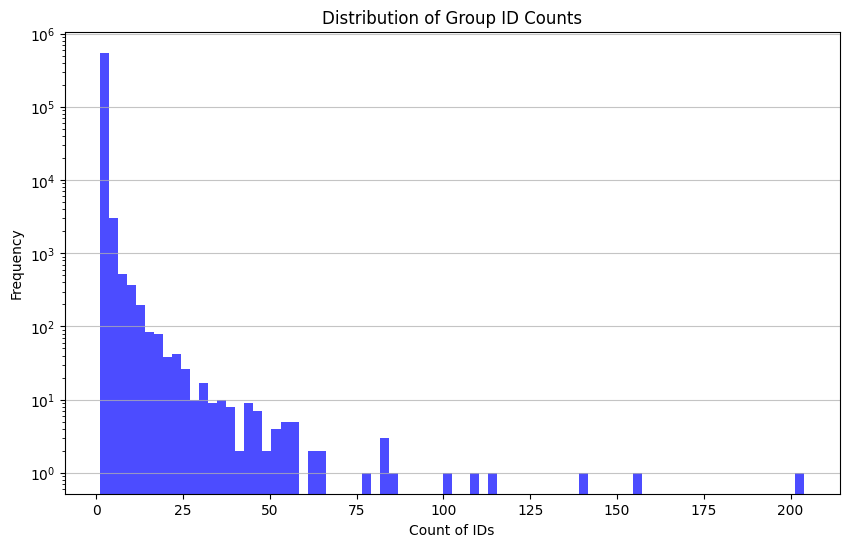

count    556172.000000
mean          1.130880
std           1.000967
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         204.000000
Name: count, dtype: float64


,label,size
id,,
raz92g59,"[Medicine, Medicine - 15-18th centuries, Medic...",204
jdrh3ssh,"[Physicians, Physicians - 20th century - Biogr...",156
rz2yv25k,"[Church buildings, Hospitals, Hospitals - Amer...",139
mkrbbsrw,"[Religion and science, Science, Science - 18th...",115
zvpgcgjv,"[Public health, Public health - 18th century, ...",110
bpg6b6gq,"[Women, Women - 18th century, Women - Albania ...",100
zbus63qt,"[AIDS (Disease), AIDS (Disease) - Africa, Sout...",85
ecudd397,"[Costume, Costume - 18th century, Costume - 19...",83
dy3k7vet,"[Medical care, Medical care - 19th century, Me...",83


In [ ]:
# plotting the distribution of group id counts
import matplotlib.pyplot as plt
type_counts = pd_combined_df.groupby("id").size().reset_index(name='count')
plt.figure(figsize=(10, 6))
plt.hist(type_counts['count'], bins=78, color='blue', alpha=0.7)
plt.title('Distribution of Group ID Counts')
plt.xlabel('Count of IDs')
plt.ylabel('Frequency')
plt.yscale('log')  # Use logarithmic scale for better visibility
plt.grid(axis='y', alpha=0.75)
plt.show()

print(type_counts["count"].describe())

# Show top 20 labels by size, make list of label text and add column with size of list with pandas
top_labels = (
    pd_combined_df.groupby("id")
    .agg({"label": lambda x: list(x), "id": "count"})
    .rename(columns={"id": "size"})
    .sort_values(by="size", ascending=False)
    .head(20)
)
top_labels



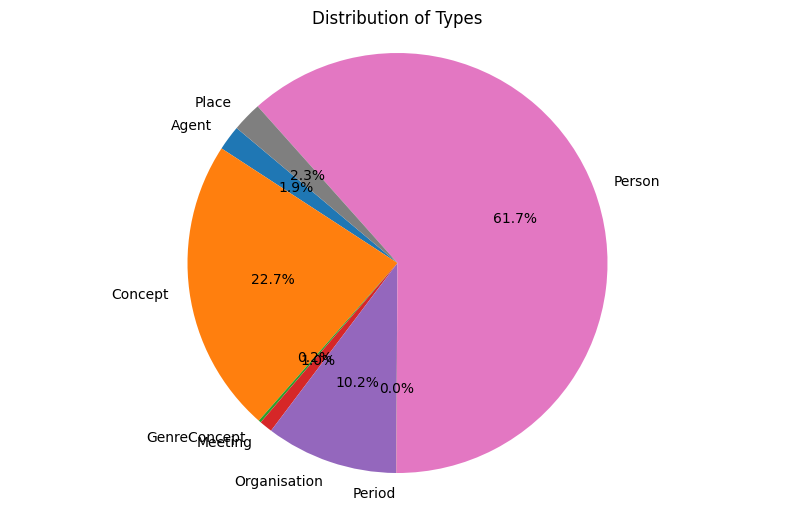

In [ ]:
# Pie chart of types    
type_counts = pd_combined_df.groupby("type").size().reset_index(name='count')
plt.figure(figsize=(10, 6))
plt.pie(type_counts['count'], labels=type_counts['type'], autopct='%0.1f%%', startangle=140)
plt.title('Distribution of Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
pd_combined_df

,label,id,type,source
0,Children,N.A.,N.A.,subject
1,Criminal law,N.A.,N.A.,subject
2,Gender roles,N.A.,N.A.,subject
3,Law,N.A.,N.A.,subject
4,Police,N.A.,N.A.,subject
...,...,...,...,...
646781,Pregnant teenagers - Great Britain - Diaries,zzzvtr3f,Concept,subject
646782,"Maddox, Lucy",zzzw65be,Person,contributor
646783,"Rockliffe, Richard William.",zzzwgbkn,Person,contributor
646784,Aneurysm - drug therapy,zzzygqw9,Concept,subject
